In [1]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns

# Options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 15)
sns.set_style("darkgrid")

This dataset was scraped by me from https://www.lamudi.com.ph/metro-manila/house/buy/

Our goal is to build a model that can predict price of houses in Metro Manila.

In [2]:
df = pd.read_csv('lamudi_house.csv')
df.head()

,title,address,bedrooms,floor_area,land_size,price
0,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,"Cupang, Muntinlupa",3.0,247.0,93.0,32539000.0
1,Likha Residences | Pre-selling 3BR 3-Storey To...,"Cupang, Muntinlupa",3.0,247.0,92.0,31111000.0
2,M-R-1-37- Acquired Property for Sale in No. 59...,"Novaliches, Quezon City",194.0,200.0,NaN,8472600.0
3,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,"Cupang, Muntinlupa",3.0,247.0,92.0,31706000.0
4,Likha Residences | Pre-selling 3BR 3-Storey To...,"Cupang, Muntinlupa",3.0,247.0,92.0,31348000.0


# Data Wranling

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       3000 non-null   object 
 1   address     3000 non-null   object 
 2   bedrooms    2999 non-null   float64
 3   floor_area  2989 non-null   float64
 4   land_size   2953 non-null   float64
 5   price       2973 non-null   float64
dtypes: float64(4), object(2)
memory usage: 140.8+ KB


In [4]:
df.shape

(3000, 6)

## Null Values

We'll drop all null values.

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       2930 non-null   object 
 1   address     2930 non-null   object 
 2   bedrooms    2930 non-null   float64
 3   floor_area  2930 non-null   float64
 4   land_size   2930 non-null   float64
 5   price       2930 non-null   float64
dtypes: float64(4), object(2)
memory usage: 160.2+ KB


In [6]:
df.describe().round()

,bedrooms,floor_area,land_size,price
count,2930.0,2930.0,2930.0,2930.0
mean,4.0,232.0,163.0,23816049.0
std,1.0,172.0,153.0,39520078.0
min,1.0,36.0,12.0,1300000.0
25%,3.0,126.0,80.0,8200000.0
50%,4.0,190.0,105.0,13000000.0
75%,4.0,288.0,189.0,25000000.0
max,12.0,3235.0,2022.0,470000000.0


## Duplicates

In [7]:
duplicates_per_column = df.apply(lambda x: f"{x.duplicated().sum():,}", axis=0)
duplicates_per_column

title           453
address       2,787
bedrooms      2,920
floor_area    2,617
land_size     2,616
price         2,479
dtype: object

In [8]:
df[df.duplicated(subset=['title', 'price'])].sort_values('title').head(15)

,title,address,bedrooms,floor_area,land_size,price
2479,2 Car Garage Townhouse For Sale in Tandang Sor...,"Tandang Sora, Quezon City",3.0,112.0,60.0,8200000.0
2024,2 Car Garage Townhouse For Sale in Tandang Sor...,"Tandang Sora, Quezon City",3.0,112.0,60.0,8200000.0
2129,2 Car Garage Townhouse For Sale in Tandang Sor...,"Tandang Sora, Quezon City",3.0,112.0,60.0,8200000.0
2381,2 Storey Brand New Modern Design Townhouse for...,"Pilar, Las Piñas",3.0,130.0,80.0,7300000.0
2742,2 Storey Brand New Townhouse For Sale in Pampl...,"Pamplona Tres, Las Piñas",3.0,86.0,77.0,5750000.0
1536,2 Storey Brand New Townhouse For Sale in Pampl...,"Pamplona Uno, Las Piñas",2.0,86.0,77.0,5750000.0
1808,2 Storey Elegant Townhouse for Sale in Fairvie...,"Fairview, Quezon City",3.0,180.0,95.0,13000000.0
2595,2 Storey Elegant Townhouse for Sale in Fairvie...,"Fairview, Quezon City",3.0,180.0,95.0,13000000.0
2232,2 Storey Elegant Townhouse for Sale in Fairvie...,"Fairview, Quezon City",3.0,180.0,95.0,13000000.0
2757,2 Storey House and Lot for Sale in Greenwoods ...,"Pinagbuhatan, Pasig",4.0,258.0,169.0,19000000.0


Let's drop the duplicate listing.

In [9]:
df = df.drop_duplicates(subset=['title', 'price'], keep='first')
df.duplicated(subset=['title', 'price']).sum()

0

## Validation

Let's split the address to district and city.

In [10]:
df[['district', 'city']] = df['address'].str.split(',', n=1, expand=True).apply(lambda x: x.str.strip())
df = df.loc[:, ~df.columns.isin(['address'])]
df.head()

,title,bedrooms,floor_area,land_size,price,district,city
0,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3.0,247.0,93.0,32539000.0,Cupang,Muntinlupa
1,Likha Residences | Pre-selling 3BR 3-Storey To...,3.0,247.0,92.0,31111000.0,Cupang,Muntinlupa
3,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3.0,247.0,92.0,31706000.0,Cupang,Muntinlupa
4,Likha Residences | Pre-selling 3BR 3-Storey To...,3.0,247.0,92.0,31348000.0,Cupang,Muntinlupa
5,Likha Residences | Pre-selling 3BR 3-Storey To...,3.0,247.0,93.0,32342000.0,Cupang,Muntinlupa


Let's check the district and city for similarity

In [11]:
from fuzzywuzzy import fuzz

def find_similarity(district_name, all_districts):
    similar_districts = []
    for d in all_districts:
        similarity_ratio = fuzz.ratio(district_name, d)
        if similarity_ratio >= 80 and district_name != d:
            similar_districts.append(d)
    return similar_districts

all_districts = df.district.unique()

for district in all_districts:
    similar_districts = find_similarity(district, all_districts)
    if similar_districts:
        print(f"Similar districts for '{district}': {', '.join(similar_districts)}")

Similar districts for 'Pulang Lupa Uno': Pulang Lupa Dos
Similar districts for 'Almanza Dos': Almanza Uno
Similar districts for 'Teachers Village West': Teachers Village East
Similar districts for 'Almanza Uno': Almanza Dos
Similar districts for 'Pamplona Uno': Pamplona Dos
Similar districts for 'Project 8': Project 4, Project 2
Similar districts for 'Ayala Heights': Loyola Heights
Similar districts for 'Manuyo Dos': Manuyo Uno
Similar districts for 'Pamplona Tres': Pamplona Dos
Similar districts for 'Pamplona Dos': Pamplona Uno, Pamplona Tres
Similar districts for 'Pulang Lupa Dos': Pulang Lupa Uno
Similar districts for 'Loyola Heights': Ayala Heights
Similar districts for 'Teachers Village East': Teachers Village West
Similar districts for 'Project 4': Project 8, Project 2
Similar districts for 'Project 2': Project 8, Project 4
Similar districts for 'Manuyo Uno': Manuyo Dos


In [12]:
df.district.unique()

array(['Cupang', 'Novaliches', 'Pulang Lupa Uno', 'Marikina Heights',
       'Fort Bonifacio', 'Almanza Dos', 'Poblacion', 'Nangka', 'Moonwalk',
       'Maytunas', 'Holy Spirit', 'Talon Singko', 'Talon Dos',
       'Tandang Sora', 'Fairview', 'Teachers Village West', 'Talon Uno',
       'Pilar', 'Almanza Uno', 'Don Bosco', 'Talon Kuatro', 'Merville',
       'B.F. Homes', 'Tunasan', 'Commonwealth', 'Pamplona Uno', 'Cubao',
       'Caloocan', 'Tuktukan', 'Ayala Alabang', 'Tondo', 'San Miguel',
       'Santa Monica', 'San Isidro', 'Batasan Hills', 'Addition Hills',
       'Laging Handa', 'Matandang Balara', 'New Manila',
       'Hagdang Bato Libis', 'Marulas', 'White Plains', 'Amparo',
       'Putatan', 'Parang', 'Project 8', 'Burol', 'San Lorenzo',
       'Tañong', 'Ayala Heights', 'Dasmariñas', 'West Crame',
       'San Martin de Porres', 'Manuyo Dos', 'Sacred Heart', 'Bel-Air',
       'Greenhills', 'Little Baguio', 'Ugong Norte', 'Bungad',
       'McKinley Hill', 'San Miguel Village'

Let's just make everything here lowered and no space. Also let's change the "ñ" to "n" and remove ".".

In [13]:
df['district'] = (
    df.district
    .str.replace(".", "", regex=False)
    .str.replace(" ", "_", regex=False)
    .str.replace("ñ", "n", regex=False)
    .str.lower()
)
df.district.unique()

array(['cupang', 'novaliches', 'pulang_lupa_uno', 'marikina_heights',
       'fort_bonifacio', 'almanza_dos', 'poblacion', 'nangka', 'moonwalk',
       'maytunas', 'holy_spirit', 'talon_singko', 'talon_dos',
       'tandang_sora', 'fairview', 'teachers_village_west', 'talon_uno',
       'pilar', 'almanza_uno', 'don_bosco', 'talon_kuatro', 'merville',
       'bf_homes', 'tunasan', 'commonwealth', 'pamplona_uno', 'cubao',
       'caloocan', 'tuktukan', 'ayala_alabang', 'tondo', 'san_miguel',
       'santa_monica', 'san_isidro', 'batasan_hills', 'addition_hills',
       'laging_handa', 'matandang_balara', 'new_manila',
       'hagdang_bato_libis', 'marulas', 'white_plains', 'amparo',
       'putatan', 'parang', 'project_8', 'burol', 'san_lorenzo', 'tanong',
       'ayala_heights', 'dasmarinas', 'west_crame',
       'san_martin_de_porres', 'manuyo_dos', 'sacred_heart', 'bel-air',
       'greenhills', 'little_baguio', 'ugong_norte', 'bungad',
       'mckinley_hill', 'san_miguel_village', 's

In [14]:
df['city'] = (
    df.city
    .str.replace(" ", "_", regex=False)
    .str.replace("ñ", "n", regex=False)
    .str.lower()
)
df.city.unique()

array(['muntinlupa', 'quezon_city', 'las_pinas', 'marikina', 'taguig',
       'makati', 'paranaque', 'san_juan', None, 'manila', 'pasig',
       'mandaluyong', 'valenzuela', 'caloocan', 'pasay'], dtype=object)

In [15]:
df.isnull().sum()

title         0
bedrooms      0
floor_area    0
land_size     0
price         0
district      0
city          6
dtype: int64

In [16]:
df = df.dropna(subset=['city'])
df.isnull().sum()

title         0
bedrooms      0
floor_area    0
land_size     0
price         0
district      0
city          0
dtype: int64

I've observed on Lamudi: many property listings seem to have inaccuracies in their reported values for both `land_size` and `floor_area`.

In [17]:
df.query('floor_area > land_size').head()

,title,bedrooms,floor_area,land_size,price,district,city
0,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3.0,247.0,93.0,32539000.0,cupang,muntinlupa
1,Likha Residences | Pre-selling 3BR 3-Storey To...,3.0,247.0,92.0,31111000.0,cupang,muntinlupa
3,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3.0,247.0,92.0,31706000.0,cupang,muntinlupa
4,Likha Residences | Pre-selling 3BR 3-Storey To...,3.0,247.0,92.0,31348000.0,cupang,muntinlupa
5,Likha Residences | Pre-selling 3BR 3-Storey To...,3.0,247.0,93.0,32342000.0,cupang,muntinlupa


Here we can see that the "FLOOR AREA" is bigger than the "LAND". We will fix this by swapping them.

In [18]:
rows_to_correct = df['floor_area'] > df['land_size']
rows_to_correct

0        True
1        True
3        True
4        True
5        True
        ...  
2995     True
2996    False
2997    False
2998    False
2999     True
Length: 2544, dtype: bool

In [19]:
df.loc[rows_to_correct, ['floor_area', 'land_size']] = df.loc[rows_to_correct, ['land_size', 'floor_area']].values
df.query('floor_area > land_size').head()

,title,bedrooms,floor_area,land_size,price,district,city


In [20]:
df.head()

,title,bedrooms,floor_area,land_size,price,district,city
0,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3.0,93.0,247.0,32539000.0,cupang,muntinlupa
1,Likha Residences | Pre-selling 3BR 3-Storey To...,3.0,92.0,247.0,31111000.0,cupang,muntinlupa
3,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3.0,92.0,247.0,31706000.0,cupang,muntinlupa
4,Likha Residences | Pre-selling 3BR 3-Storey To...,3.0,92.0,247.0,31348000.0,cupang,muntinlupa
5,Likha Residences | Pre-selling 3BR 3-Storey To...,3.0,93.0,247.0,32342000.0,cupang,muntinlupa


## Changing Dtypes

In [21]:
df.describe().round(1)

,bedrooms,floor_area,land_size,price
count,2544.0,2544.0,2544.0,2544.0
mean,3.8,146.3,245.8,23909364.7
std,1.0,116.4,189.9,40079807.1
min,1.0,19.0,40.0,2500000.0
25%,3.0,75.0,129.0,8200000.0
50%,4.0,100.0,192.0,13000000.0
75%,4.0,180.0,298.0,25000000.0
max,12.0,1190.0,3235.0,470000000.0


In [22]:
dtypes = {
    'bedrooms': 'int8',
    'floor_area': 'float16',
    'land_size': 'float16',
    'price': 'int32',
    'district': 'category',
    'city': 'category'
}
df = df.astype(dtypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   title       2544 non-null   object  
 1   bedrooms    2544 non-null   int8    
 2   floor_area  2544 non-null   float16 
 3   land_size   2544 non-null   float16 
 4   price       2544 non-null   int32   
 5   district    2544 non-null   category
 6   city        2544 non-null   category
dtypes: category(2), float16(2), int32(1), int8(1), object(1)
memory usage: 75.3+ KB


# EDA

Let's make some features to use for our model, so far we have city and district. Maybe we can extract some values using the title.

In [23]:
df_copy = df.copy()
df_copy.head()

,title,bedrooms,floor_area,land_size,price,district,city
0,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3,93.0,247.0,32539000,cupang,muntinlupa
1,Likha Residences | Pre-selling 3BR 3-Storey To...,3,92.0,247.0,31111000,cupang,muntinlupa
3,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3,92.0,247.0,31706000,cupang,muntinlupa
4,Likha Residences | Pre-selling 3BR 3-Storey To...,3,92.0,247.0,31348000,cupang,muntinlupa
5,Likha Residences | Pre-selling 3BR 3-Storey To...,3,93.0,247.0,32342000,cupang,muntinlupa


Okay first one I noticed is that there is a "pre-selling", so we can make a new feature sale_type that has presale or sale.

In [24]:
# Function to check if a title is similar to a list of terms
def is_similar(title, terms):
    title_lower = title.lower()
    for term in terms:
        similarity = fuzz.partial_ratio(term, title_lower)
        if similarity >= 80:
            return True
    return False

pre_selling_terms = ['pre-sell', 'pre-selling', 'pre-sale']

# Apply the function to filter titles
filtered_df = df_copy[df_copy['title'].apply(is_similar, terms=pre_selling_terms)]
filtered_df

,title,bedrooms,floor_area,land_size,price,district,city
0,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3,93.0,247.0,32539000,cupang,muntinlupa
1,Likha Residences | Pre-selling 3BR 3-Storey To...,3,92.0,247.0,31111000,cupang,muntinlupa
3,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3,92.0,247.0,31706000,cupang,muntinlupa
4,Likha Residences | Pre-selling 3BR 3-Storey To...,3,92.0,247.0,31348000,cupang,muntinlupa
5,Likha Residences | Pre-selling 3BR 3-Storey To...,3,93.0,247.0,32342000,cupang,muntinlupa
...,...,...,...,...,...,...,...
1602,10-12 Months To Pay DP Pre-selling House and L...,4,80.0,208.0,10578000,pilar,las_pinas
1727,"11.3M, 8.4M, 7.6M - Pre Selling Townhouse in R...",4,63.0,212.0,11300000,concepcion_dos,marikina
1829,2 Storey Pre selling Duplex House in BF Resort...,4,102.0,180.0,13000000,talon_dos,las_pinas
1852,Pre-selling Customized House For Sale in North...,3,69.0,70.0,5400000,novaliches,quezon_city


We only have 33 pre-sell so the rest is for sale.

In [25]:
df_copy['sale_type'] = df_copy.title.apply(is_similar, terms=pre_selling_terms)
df_copy['sale_type'] = df_copy.sale_type.map({True: 'presale', False: 'sale'})
df_copy.sale_type.unique()

array(['presale', 'sale'], dtype=object)

Let's try making another feature, as I see there are brand new and pre-owned listing. We'll name this condition.

In [26]:
# List of terms to check for similarity
pre_owned_terms = ['pre-owned']

# Apply the function to filter titles
filtered_df = df_copy[df_copy['title'].apply(is_similar, terms=pre_owned_terms)]
filtered_df

,title,bedrooms,floor_area,land_size,price,district,city,sale_type
39,Pre-owned Spacious Bungalow House in BF Resort...,3,200.0,236.0,12000000,talon_uno,las_pinas,sale
67,Pre-owned Well Maintained Classic Bungalow wit...,3,300.0,408.0,23500000,bf_homes,paranaque,sale
77,Spacious Pre-Owned Classic Bungalow House with...,3,300.0,408.0,23500000,bf_homes,paranaque,sale
117,Pre-owned Modern Townhouse for Sale in Marikin...,4,103.0,146.0,8500000,marikina_heights,marikina,sale
120,"Pre-Owned Properly Maintained, Fully Furnished...",3,180.0,240.0,16000000,san_isidro,paranaque,sale
...,...,...,...,...,...,...,...,...
2107,Pre Owned Bungalow Split Level In South Admira...,5,250.0,360.0,24000000,merville,paranaque,sale
2587,Pre Owned 2 Storey House and Lot for Sale in F...,5,240.0,300.0,17500000,batasan_hills,quezon_city,sale
2727,Pre-Owned Well Maintained House and Lot in Bf ...,5,187.0,360.0,23000000,talon_dos,las_pinas,sale
2886,Pre Owned Well Maintained House and Lot for sa...,4,200.0,240.0,17500000,don_bosco,paranaque,sale


In [27]:
df_copy['condition'] = df_copy['title'].apply(is_similar, terms=pre_owned_terms)
df_copy['condition'] = df_copy['condition'].map({True: 'pre_owned', False: 'new'})
df_copy.condition.unique()

array(['new', 'pre_owned'], dtype=object)

In [28]:
df_copy.query('condition == "pre_owned"')

,title,bedrooms,floor_area,land_size,price,district,city,sale_type,condition
39,Pre-owned Spacious Bungalow House in BF Resort...,3,200.0,236.0,12000000,talon_uno,las_pinas,sale,pre_owned
67,Pre-owned Well Maintained Classic Bungalow wit...,3,300.0,408.0,23500000,bf_homes,paranaque,sale,pre_owned
77,Spacious Pre-Owned Classic Bungalow House with...,3,300.0,408.0,23500000,bf_homes,paranaque,sale,pre_owned
117,Pre-owned Modern Townhouse for Sale in Marikin...,4,103.0,146.0,8500000,marikina_heights,marikina,sale,pre_owned
120,"Pre-Owned Properly Maintained, Fully Furnished...",3,180.0,240.0,16000000,san_isidro,paranaque,sale,pre_owned
...,...,...,...,...,...,...,...,...,...
2107,Pre Owned Bungalow Split Level In South Admira...,5,250.0,360.0,24000000,merville,paranaque,sale,pre_owned
2587,Pre Owned 2 Storey House and Lot for Sale in F...,5,240.0,300.0,17500000,batasan_hills,quezon_city,sale,pre_owned
2727,Pre-Owned Well Maintained House and Lot in Bf ...,5,187.0,360.0,23000000,talon_dos,las_pinas,sale,pre_owned
2886,Pre Owned Well Maintained House and Lot for sa...,4,200.0,240.0,17500000,don_bosco,paranaque,sale,pre_owned


Let's check for fully/semi furnished. We'll just make a 2 category type again if its furnished or not.

In [29]:
furnish_terms = ['furnished', 'furnish']

# Apply the function to filter titles
filtered_df = df_copy[df_copy['title'].apply(is_similar, terms=furnish_terms)]
filtered_df

,title,bedrooms,floor_area,land_size,price,district,city,sale_type,condition
35,Semi Furnished New Townhouse for Sale in West ...,3,95.0,180.0,13000000,fairview,quezon_city,sale,new
75,For sale Fully Furnished 2 Storey’s Townhouse ...,4,167.0,220.0,14700000,talon_dos,las_pinas,sale,new
94,4 Bedrooms Fully Furnished House & Lot in BF R...,4,152.0,375.0,25000000,talon_uno,las_pinas,sale,new
99,House for Sale in Las Pinas City Versailles Vi...,6,355.0,520.0,80000000,almanza_dos,las_pinas,sale,new
103,Fully Renovated and furnished One Storey House...,4,280.0,300.0,25000000,bf_homes,paranaque,sale,new
...,...,...,...,...,...,...,...,...,...
2571,3 Storey SEMI FURNISHED House and Lot for sale...,5,150.0,350.0,29800000,matandang_balara,quezon_city,sale,new
2610,For Sale Single Detached Semi Furnished House ...,4,300.0,400.0,33600000,fairview,quezon_city,sale,new
2771,For Sale Semi-Furnished Three (3) Storey Singl...,5,187.0,360.0,23000000,talon_dos,las_pinas,sale,new
2879,For Sale Semi-Furnished Newly Built Modern Ele...,5,222.0,328.0,24000000,talon_dos,las_pinas,sale,new


In [30]:
# Apply the function to filter titles
df_copy['furnished_status'] = df_copy.title.apply(is_similar, terms=furnish_terms)
df_copy['furnished_status'] = df_copy.furnished_status.map({True: 'yes', False: 'no'})
df_copy.condition.unique()

array(['new', 'pre_owned'], dtype=object)

In [31]:
df_copy.query('furnished_status == "yes"')

,title,bedrooms,floor_area,land_size,price,district,city,sale_type,condition,furnished_status
35,Semi Furnished New Townhouse for Sale in West ...,3,95.0,180.0,13000000,fairview,quezon_city,sale,new,yes
75,For sale Fully Furnished 2 Storey’s Townhouse ...,4,167.0,220.0,14700000,talon_dos,las_pinas,sale,new,yes
94,4 Bedrooms Fully Furnished House & Lot in BF R...,4,152.0,375.0,25000000,talon_uno,las_pinas,sale,new,yes
99,House for Sale in Las Pinas City Versailles Vi...,6,355.0,520.0,80000000,almanza_dos,las_pinas,sale,new,yes
103,Fully Renovated and furnished One Storey House...,4,280.0,300.0,25000000,bf_homes,paranaque,sale,new,yes
...,...,...,...,...,...,...,...,...,...,...
2571,3 Storey SEMI FURNISHED House and Lot for sale...,5,150.0,350.0,29800000,matandang_balara,quezon_city,sale,new,yes
2610,For Sale Single Detached Semi Furnished House ...,4,300.0,400.0,33600000,fairview,quezon_city,sale,new,yes
2771,For Sale Semi-Furnished Three (3) Storey Singl...,5,187.0,360.0,23000000,talon_dos,las_pinas,sale,new,yes
2879,For Sale Semi-Furnished Newly Built Modern Ele...,5,222.0,328.0,24000000,talon_dos,las_pinas,sale,new,yes


## Distribution

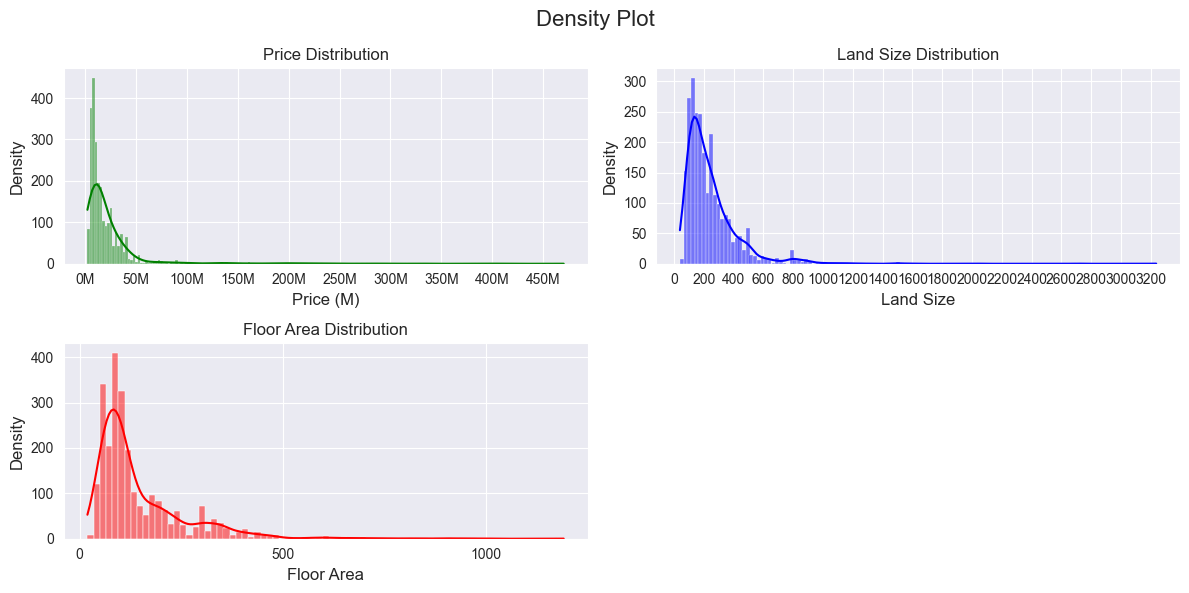

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Price
sns.histplot(data=df_copy, x='price', kde=True, color='green', ax=ax[0, 0])
ax[0, 0].set_title('Price Distribution')
ax[0, 0].set_xlabel('Price (M)', fontsize=12)
ax[0, 0].set_ylabel('Density', fontsize=12)

# Create a formatter to display y-ticks in millions
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000):,}M')
ax[0, 0].xaxis.set_major_formatter(formatter)
ax[0, 0].xaxis.set_major_locator(ticker.MultipleLocator(base=50_000_000))

# SQM
sns.histplot(data=df_copy, x='floor_area', kde=True, color='red', ax=ax[1, 0])
ax[1, 0].set_title('Floor Area Distribution')
ax[1, 0].set_xlabel("Floor Area", fontsize=12)
ax[1, 0].set_ylabel('Density', fontsize=12)
ax[1, 0].xaxis.set_major_locator(ticker.MultipleLocator(base=500))

# Land Size SQM
sns.histplot(data=df_copy, x='land_size', kde=True, color='blue', ax=ax[0, 1])
ax[0, 1].set_title('Land Size Distribution')
ax[0, 1].set_xlabel("Land Size", fontsize=12)
ax[0, 1].set_ylabel('Density', fontsize=12)
ax[0, 1].xaxis.set_major_locator(ticker.MultipleLocator(base=200))

# Remove the unused subplot
fig.delaxes(ax[1, 1])

fig.suptitle("Density Plot", fontsize=16)
plt.tight_layout()
plt.show()

Our data shows right-skewed (positively skewed). This means that there are a few larger values on the right side of the distribution. Let's use np.log to reduce the skewness. 

We can also remove the outliers first before doing this to have better distribution. But some houses are really expensive depends on the location.

In [33]:
df_copy.query('price > 200_000_000')

,title,bedrooms,floor_area,land_size,price,district,city,sale_type,condition,furnished_status
109,5 Bedroom House & Lot for Sale at Ayala Alaban...,5,868.0,1600.0,385000000,ayala_alabang,muntinlupa,sale,new,no
110,"Ayala Alabang Brand New Modern House 1,100sqm ...",5,980.0,1100.0,450000000,ayala_alabang,muntinlupa,sale,new,no
148,White Plains 12 BR Modern Contemporary House a...,12,700.0,2700.0,298000000,white_plains,quezon_city,sale,new,no
149,Brand New House For Sale in Ayala Alabang Vill...,7,900.0,1500.0,470000000,ayala_alabang,muntinlupa,sale,new,no
155,Brand New House and Lot For Sale in White Plai...,7,464.0,900.0,208000000,white_plains,quezon_city,sale,new,no
...,...,...,...,...,...,...,...,...,...,...
933,Valle Verde House and Lot for Sale! Pasig City,5,754.0,1288.0,330000000,ugong,pasig,sale,new,no
953,Well Maintained Duplex House for Sale at Bel A...,3,363.0,525.0,270000000,bel-air,makati,sale,new,no
954,"Bel Air Village, Makati - Brand New Modern Dup...",5,411.0,704.0,325000000,bel-air,makati,sale,new,no
963,Prime Modern House and lot for sale at New Man...,5,800.0,1002.0,250000000,mariana,quezon_city,sale,new,no


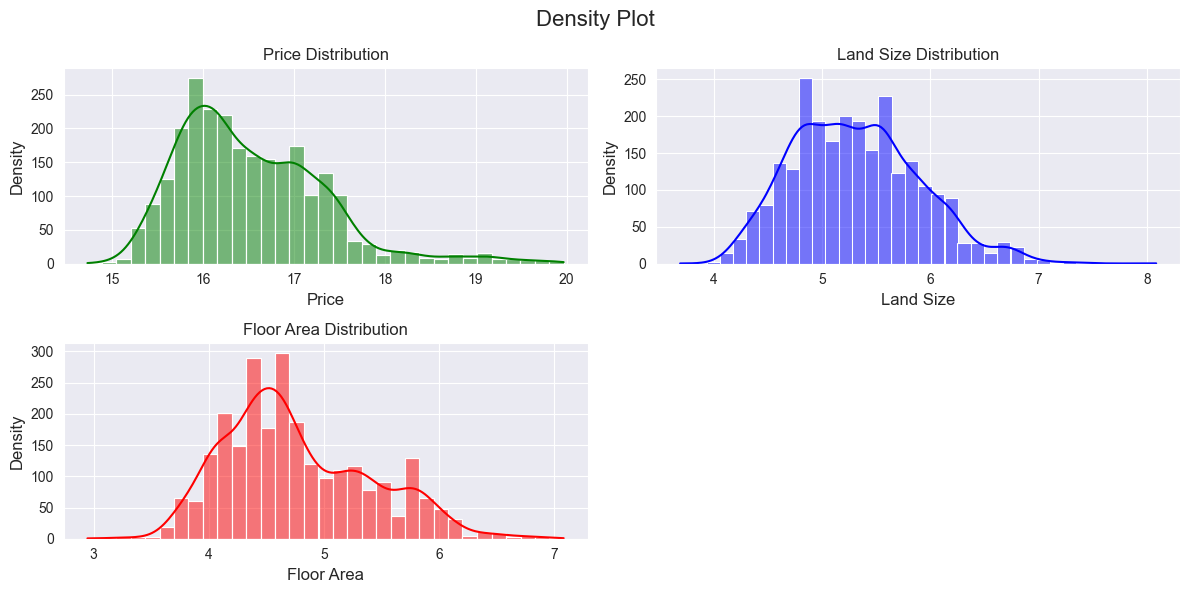

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Price
sns.histplot(x=np.log(df_copy.price), kde=True, color='green', ax=ax[0, 0])
ax[0, 0].set_title('Price Distribution')
ax[0, 0].set_xlabel('Price', fontsize=12)
ax[0, 0].set_ylabel('Density', fontsize=12)

# Create a formatter to display y-ticks in millions
ax[0, 0].xaxis.set_major_locator(ticker.MultipleLocator(base=1))

# SQM
sns.histplot(x=np.log(df_copy.floor_area), kde=True, color='red', ax=ax[1, 0])
ax[1, 0].set_title('Floor Area Distribution')
ax[1, 0].set_xlabel("Floor Area", fontsize=12)
ax[1, 0].set_ylabel('Density', fontsize=12)
ax[1, 0].xaxis.set_major_locator(ticker.MultipleLocator(base=1))

# Land Size SQM
sns.histplot(x=np.log(df_copy.land_size), kde=True, color='blue', ax=ax[0, 1])
ax[0, 1].set_title('Land Size Distribution')
ax[0, 1].set_xlabel("Land Size", fontsize=12)
ax[0, 1].set_ylabel('Density', fontsize=12)
ax[0, 1].xaxis.set_major_locator(ticker.MultipleLocator(base=1))

# Remove the unused subplot
fig.delaxes(ax[1, 1])

fig.suptitle("Density Plot", fontsize=16)
plt.tight_layout()
plt.show()

# Predicting House Prices in Metromanila

Let's transform values to log

In [35]:
train_df = df_copy.copy()

train_df['price'] = np.log(train_df['price'])
train_df['floor_area'] = np.log(train_df['floor_area'])
train_df['land_size'] = np.log(train_df['land_size'])
train_df.head()

,title,bedrooms,floor_area,land_size,price,district,city,sale_type,condition,furnished_status
0,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3,4.531250,5.507812,17.297950,cupang,muntinlupa,presale,new,no
1,Likha Residences | Pre-selling 3BR 3-Storey To...,3,4.523438,5.507812,17.253072,cupang,muntinlupa,presale,new,no
3,Pre-selling 3BR 3-Storey Townhouse for Sale ne...,3,4.523438,5.507812,17.272016,cupang,muntinlupa,presale,new,no
4,Likha Residences | Pre-selling 3BR 3-Storey To...,3,4.523438,5.507812,17.260661,cupang,muntinlupa,presale,new,no
5,Likha Residences | Pre-selling 3BR 3-Storey To...,3,4.531250,5.507812,17.291877,cupang,muntinlupa,presale,new,no


Let's also drop the title since we already have some feature to use and let's transform the feature to binary

In [36]:
train_df = train_df.loc[:, ~train_df.columns.isin(['title'])]

dummies = pd.get_dummies(train_df[['city', 'district', 'sale_type', 'condition', 'furnished_status']], prefix='', prefix_sep='')
dummies

,caloocan,las_pinas,makati,mandaluyong,manila,marikina,muntinlupa,paranaque,pasay,pasig,quezon_city,san_juan,taguig,valenzuela,addition_hills,alabang,almanza_dos,almanza_uno,amparo,apolonio_samson,ayala_alabang,ayala_heights,bagbag,bagong_ilog,bagong_lipunan_ng_crame,bagong_pag-asa,bagong_silangan,bagumbayan,bagumbong,bahay_toro,balong-bato,bambang,batasan_hills,bel-air,bf_homes,bf_international_village,bignay,bungad,burol,camarin,capitol_hills,commonwealth,concepcion_dos,congressional_avenue,cubao,culiat,cupang,dasmarinas,del_monte,deparo,...,pulang_lupa_dos,pulang_lupa_uno,putatan,quiapo,rosario,roxas,sacred_heart,saint_ignatius,san_bartolome,san_isidro,san_jose,san_lorenzo,san_martin_de_porres,san_miguel,san_miguel_village,santa_cruz,santa_lucia,santa_monica,sauyo,sikatuna_village,south_triangle,sucat,sun_valley,talipapa,talon_dos,talon_kuatro,talon_singko,talon_uno,tandang_sora,tanong,teachers_village_east,teachers_village_west,tondo,tuktukan,tunasan,ugong,ugong_norte,urdaneta,ususan,valle_verde_6,west_crame,west_kamias,western_bicutan,white_plains,presale,sale,new,pre_owned,no,yes
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
2996,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
2997,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
2998,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0


In [37]:
train_df = pd.concat([train_df, dummies], axis=1)
train_df = train_df.drop(['city', 'district', 'sale_type', 'condition', 'furnished_status'], axis=1)
train_df.head()

,bedrooms,floor_area,land_size,price,caloocan,las_pinas,makati,mandaluyong,manila,marikina,muntinlupa,paranaque,pasay,pasig,quezon_city,san_juan,taguig,valenzuela,addition_hills,alabang,almanza_dos,almanza_uno,amparo,apolonio_samson,ayala_alabang,ayala_heights,bagbag,bagong_ilog,bagong_lipunan_ng_crame,bagong_pag-asa,bagong_silangan,bagumbayan,bagumbong,bahay_toro,balong-bato,bambang,batasan_hills,bel-air,bf_homes,bf_international_village,bignay,bungad,burol,camarin,capitol_hills,commonwealth,concepcion_dos,congressional_avenue,cubao,culiat,...,pulang_lupa_dos,pulang_lupa_uno,putatan,quiapo,rosario,roxas,sacred_heart,saint_ignatius,san_bartolome,san_isidro,san_jose,san_lorenzo,san_martin_de_porres,san_miguel,san_miguel_village,santa_cruz,santa_lucia,santa_monica,sauyo,sikatuna_village,south_triangle,sucat,sun_valley,talipapa,talon_dos,talon_kuatro,talon_singko,talon_uno,tandang_sora,tanong,teachers_village_east,teachers_village_west,tondo,tuktukan,tunasan,ugong,ugong_norte,urdaneta,ususan,valle_verde_6,west_crame,west_kamias,western_bicutan,white_plains,presale,sale,new,pre_owned,no,yes
0,3,4.531250,5.507812,17.297950,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,3,4.523438,5.507812,17.253072,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,3,4.523438,5.507812,17.272016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4,3,4.523438,5.507812,17.260661,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
5,3,4.531250,5.507812,17.291877,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [38]:
train_df.columns

Index(['bedrooms', 'floor_area', 'land_size', 'price', 'caloocan', 'las_pinas',
       'makati', 'mandaluyong', 'manila', 'marikina',
       ...
       'west_crame', 'west_kamias', 'western_bicutan', 'white_plains',
       'presale', 'sale', 'new', 'pre_owned', 'no', 'yes'],
      dtype='object', length=160)

Correlation

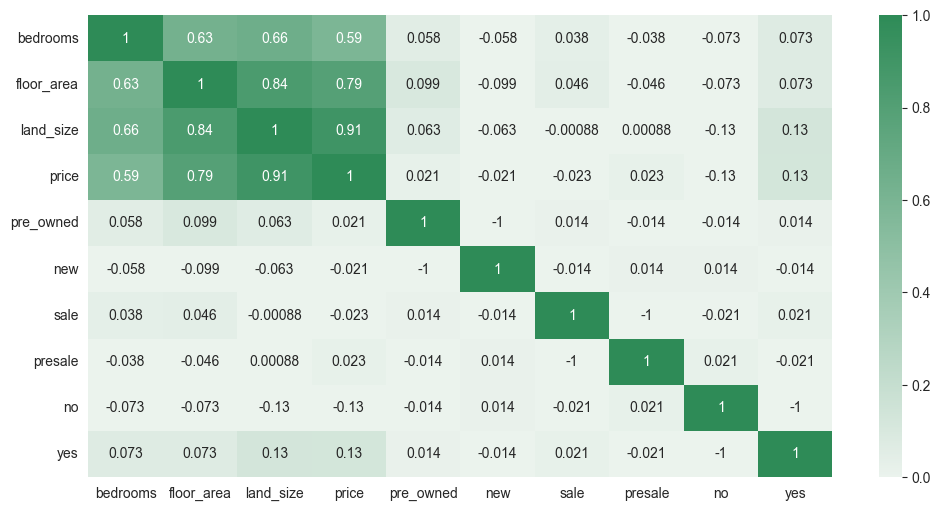

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    data=train_df[['bedrooms', 'floor_area', 'land_size', 'price', 'pre_owned', 'new', 'sale', 'presale', 'no', 'yes']].corr(numeric_only=True), 
    vmin=0, 
    vmax=1, 
    annot=True, 
    cmap=sns.light_palette("seagreen", as_cmap=True),
    ax=ax
);

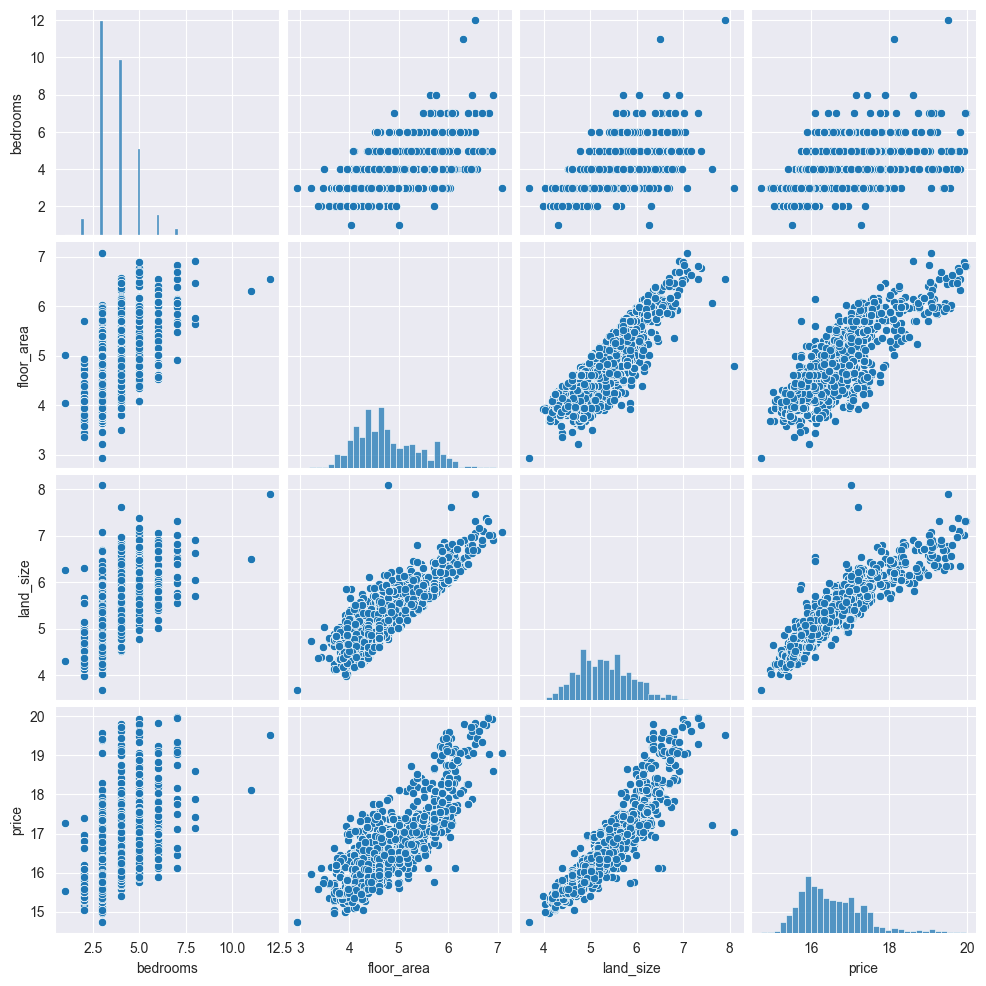

In [40]:
sns.pairplot(
    data=train_df[['bedrooms', 'floor_area', 'land_size', 'price']]
);

# Training Models

I won't be fine-tuning the models by searching for the best hyperparameters. Instead, I'll be sticking with their default settings.

## Random Forest Regressor

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Save X and y data into variables
X = train_df.loc[:, ~train_df.columns.isin(['price'])]
y = train_df["price"]

# Split dataset into training and holdout datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

# Create the pipeline with StandardScaler, and RandomForestRegressor
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor())
])

# Create the GridSearchCV object
forest = pipe.fit(X_train, y_train)

In [42]:
forest.score(X_test, y_test), forest.score(X, y)

(0.9397106621940562, 0.9762537902453401)

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE Train: {mae_train:,.2f}")
print(f"MAE Test: {mae_test:,.2f}")

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE Train: {rmse_train:,.2f}")
print(f"RMSE Test: {rmse_test:,.2f}")

MAE Train: 0.04
MAE Test: 0.09
RMSE Train: 0.08
RMSE Test: 0.20


In [44]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set up KFold
kf = KFold(n_splits=5, shuffle=True, random_state=16)

mae_train_scores = []
mae_test_scores = []
rmse_train_scores = []
rmse_test_scores = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    forest.fit(X_train_fold, y_train_fold)
    y_train_pred = forest.predict(X_train_fold)
    y_test_pred = forest.predict(X_test_fold)

    # Calculate MAE
    mae_train = mean_absolute_error(y_train_fold, y_train_pred)
    mae_test = mean_absolute_error(y_test_fold, y_test_pred)
    mae_train_scores.append(mae_train)
    mae_test_scores.append(mae_test)

    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test_fold, y_test_pred))
    rmse_train_scores.append(rmse_train)
    rmse_test_scores.append(rmse_test)

# Calculate the mean scores over all folds
mean_mae_train = np.mean(mae_train_scores)
mean_mae_test = np.mean(mae_test_scores)
mean_rmse_train = np.mean(rmse_train_scores)
mean_rmse_test = np.mean(rmse_test_scores)

# Mean scores
print(f"Kfold Mean MAE Train: {mean_mae_train:,.2f}")
print(f"Kfold Mean MAE Test: {mean_mae_test:,.2f}")
print(f"Kfold Mean RMSE Train: {mean_rmse_train:,.2f}")
print(f"Kfold Mean RMSE Test: {mean_rmse_test:,.2f}")

Kfold Mean MAE Train: 0.04
Kfold Mean MAE Test: 0.11
Kfold Mean RMSE Train: 0.08
Kfold Mean RMSE Test: 0.21


In [45]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and calculate RMSE scores
cv_scores = cross_val_score(forest, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Perform cross-validation and calculate MAE scores using custom scoring function
cv_scores_mae = cross_val_score(forest, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae_scores = -cv_scores_mae 

print("Cross-Validation RMSE Scores:", np.mean(cv_rmse_scores))
print("Cross-Validation MAE Scores:", np.mean(cv_mae_scores))

Cross-Validation RMSE Scores: 0.21015923620819738
Cross-Validation MAE Scores: 0.11860168181351693


In [46]:
y_test_pred = forest.predict(X_test)

# Create a new DataFrame with original land_size, floor_area, bedrooms, actual prices, and predicted prices
predicted_df = pd.DataFrame({
    'floor_area': np.exp(X_test.floor_area),
    'bedrooms': X_test.bedrooms,
    'land_size': np.exp(X_test.land_size),
    'price': np.exp(y_test).round().astype('int64'),
    'predicted_price': np.exp(y_test_pred).round().astype('int64')
})

predicted_df.sort_values('price', ascending=False).sample(5, random_state=16)

,floor_area,bedrooms,land_size,price,predicted_price
450,127.9375,3,145.0000,9500000,9232055
2105,439.7500,6,504.0000,45000000,44446372
2404,158.0000,4,310.5000,21770000,21929915
620,98.1250,2,159.8750,7400000,7600739
2711,80.0625,3,95.8125,6400000,7174395


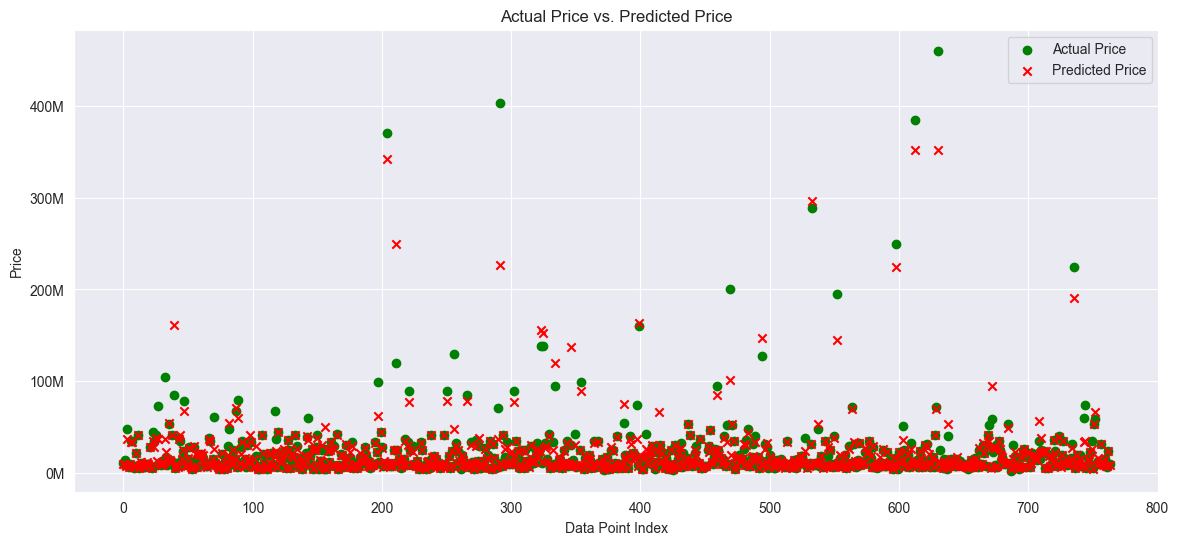

In [47]:
fig, ax = plt.subplots(figsize=(14, 6))

plt.scatter(x=range(len(predicted_df)), y=predicted_df.price, color='green', label="Actual Price")
plt.scatter(x=range(len(predicted_df)), y=predicted_df.predicted_price, color='red', marker="x", label="Predicted Price")

plt.title("Actual Price vs. Predicted Price")
plt.xlabel("Data Point Index")
plt.ylabel("Price")

# Get the y-axis object and set the formatter
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000):,}M')
ax.yaxis.set_major_formatter(formatter)

plt.legend()
plt.show()

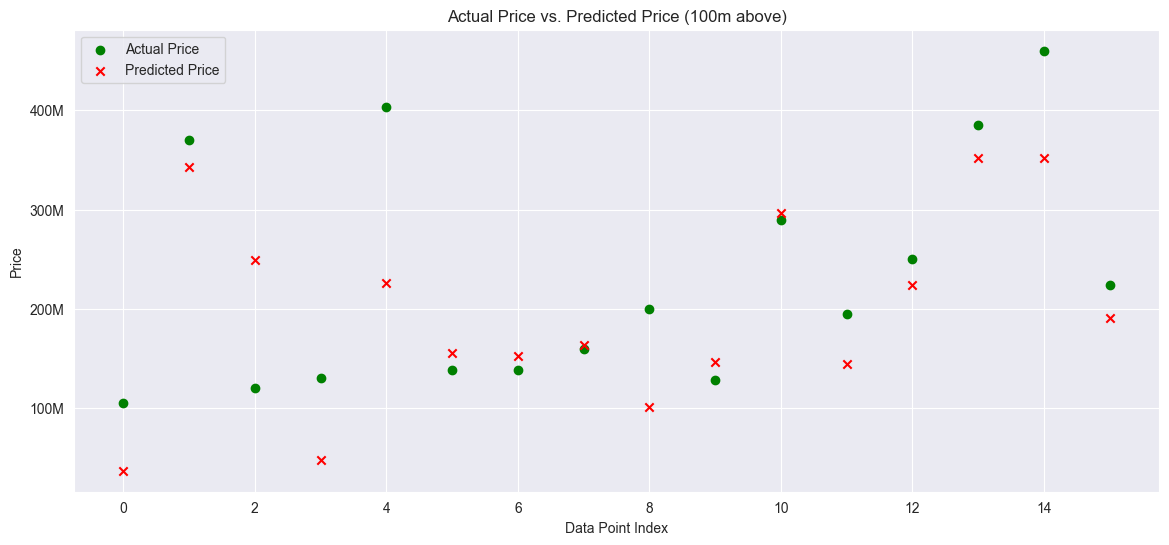

In [48]:
predicted_df = predicted_df.query('price > 100_000_000')
fig, ax = plt.subplots(figsize=(14, 6))

plt.scatter(x=range(len(predicted_df)), y=predicted_df.price, color='green', label="Actual Price")
plt.scatter(x=range(len(predicted_df)), y=predicted_df.predicted_price, color='red', marker="x", label="Predicted Price")

plt.title("Actual Price vs. Predicted Price (100m above)")
plt.xlabel("Data Point Index")
plt.ylabel("Price")

# Get the y-axis object and set the formatter
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000):,}M')
ax.yaxis.set_major_formatter(formatter)

plt.legend()
plt.show()

### Learning Curve

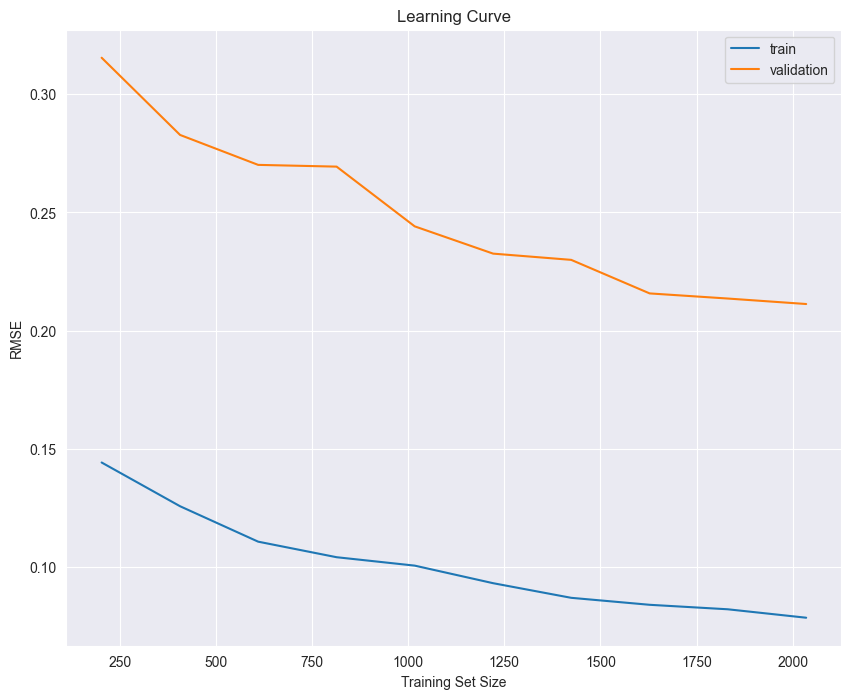

In [49]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=forest,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=2
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

With an increase in the training set size, both the train and validation losses exhibit a decreasing trend. This trend indicates that the model is finding a better fit to the data without encountering issues of overfitting or underfitting. Expanding the training data further is likely to continue enhancing the model's performance and generalization capabilities.

## Ridge Regression

In [50]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = train_df.loc[:, ~train_df.columns.isin(['price'])]
y = train_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', Ridge())
])

ridge = pipe.fit(X_train, y_train)

In [51]:
ridge.score(X_test, y_test), ridge.score(X, y)

(0.9233693630010508, 0.9398959771774744)

In [52]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

cv_scores_mae = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae_scores = -cv_scores_mae 

print("Cross-Validation RMSE Scores:", np.mean(cv_rmse_scores))
print("Cross-Validation MAE Scores:", np.mean(cv_mae_scores))

Cross-Validation RMSE Scores: 0.22120506124603517
Cross-Validation MAE Scores: 0.15583116568990585


### Learning Curve

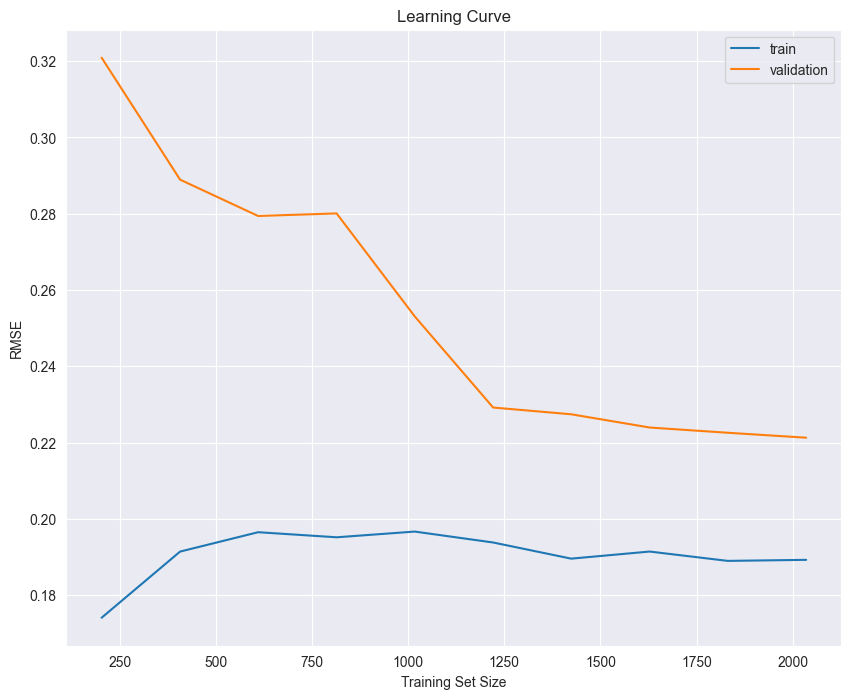

In [53]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=ridge,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=2
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

## Epsilon-Support Vector Regression

In [54]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = train_df.loc[:, ~train_df.columns.isin(['price'])]
y = train_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', SVR(kernel='linear'))  # Linear is better than default
])

svr = pipe.fit(X_train, y_train)

In [55]:
svr.score(X_test, y_test), svr.score(X, y)

(0.9239538737294403, 0.9381768428371838)

In [56]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(svr, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

cv_scores_mae = cross_val_score(svr, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae_scores = -cv_scores_mae 

print("Cross-Validation RMSE Scores:", np.mean(cv_rmse_scores))
print("Cross-Validation MAE Scores:", np.mean(cv_mae_scores))

Cross-Validation RMSE Scores: 0.22633644338492065
Cross-Validation MAE Scores: 0.15973709319630716


### Learning Curve

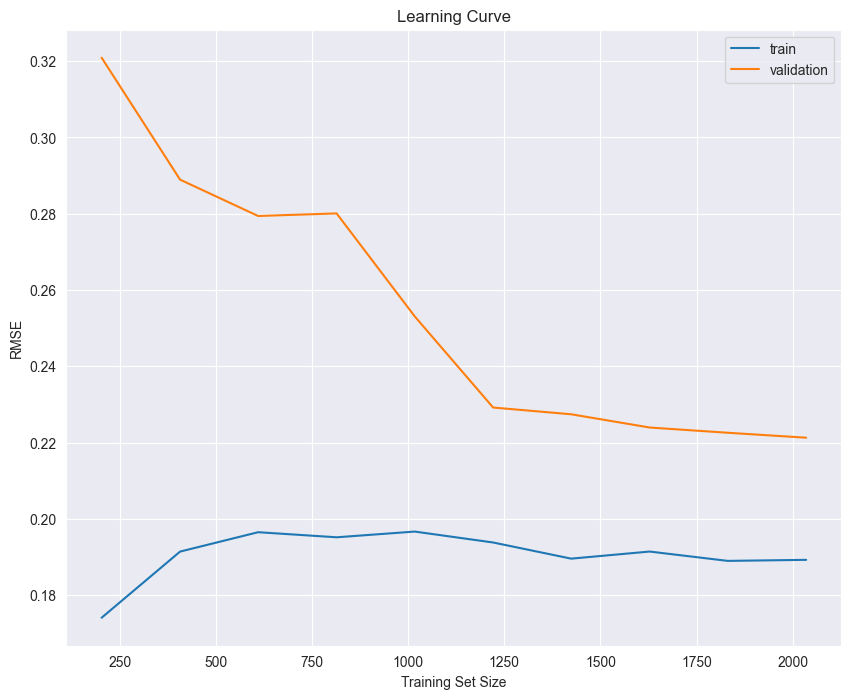

In [57]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=ridge,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=2
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

## XGBoost

In [58]:
def custom_rmse(y_pred, dtrain):
    y_true = dtrain.get_label()  # Get the true labels from the DMatrix

    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)

    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return ("custom_rmse", rmse)

In [59]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X = train_df.loc[:, ~train_df.columns.isin(['price'])]
y = train_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

# convert numpy arrays to xgb Dmatrix format
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
d_X = xgb.DMatrix(X, label=y)

# specify validations set to watch performance
watchlist = [(d_train, 'train'), (d_test, 'eval')]

params = {
    "max_depth": 20,
    "objective": "reg:squarederror",
    "subsample": 0.6667, # .6667
    'colsample_bytree':0.5,
    "lambda": 100,
    'min_child_weight':1,
    'tree_method':'hist',
    "learning_rate": 0.05,
    "eval_metric": "rmse"
}

num_round = 3000
early_stop = 100

evals_results = {}

xgb_model = xgb.train(
    params=params, dtrain=d_train, num_boost_round=num_round, 
    custom_metric=custom_rmse, maximize=False, obj=None, 
    evals=watchlist, verbose_eval=200, evals_result=evals_results,
    early_stopping_rounds=early_stop
)

[0]	train-rmse:15.33297	train-custom_rmse:47741144.00000	eval-rmse:15.28162	eval-custom_rmse:44048144.00000
[200]	train-rmse:0.22505	train-custom_rmse:26165686.00000	eval-rmse:0.23320	eval-custom_rmse:25245730.00000
[400]	train-rmse:0.14610	train-custom_rmse:15150804.00000	eval-rmse:0.18684	eval-custom_rmse:16740203.00000
[600]	train-rmse:0.12059	train-custom_rmse:11395755.00000	eval-rmse:0.17718	eval-custom_rmse:13497220.00000
[800]	train-rmse:0.10618	train-custom_rmse:9865095.00000	eval-rmse:0.17331	eval-custom_rmse:11967891.00000
[1000]	train-rmse:0.09543	train-custom_rmse:8725478.00000	eval-rmse:0.17141	eval-custom_rmse:10988799.00000
[1200]	train-rmse:0.08650	train-custom_rmse:7880883.50000	eval-rmse:0.17030	eval-custom_rmse:10424280.00000
[1400]	train-rmse:0.07981	train-custom_rmse:7187965.50000	eval-rmse:0.16983	eval-custom_rmse:10053805.00000
[1600]	train-rmse:0.07434	train-custom_rmse:6612799.50000	eval-rmse:0.16968	eval-custom_rmse:9805171.00000
[1800]	train-rmse:0.06927	trai

In [60]:
from sklearn.metrics import r2_score

# Train scores
train_predictions = xgb_model.predict(d_train)
train_r2 = r2_score(y_train, train_predictions)

print("Training R-squared:", train_r2)

# Test scores
test_predictions = xgb_model.predict(d_test)
test_r2 = r2_score(y_test, test_predictions)

print("Testing R-squared:", test_r2)

Training R-squared: 0.9943307666232837
Testing R-squared: 0.955454716100271


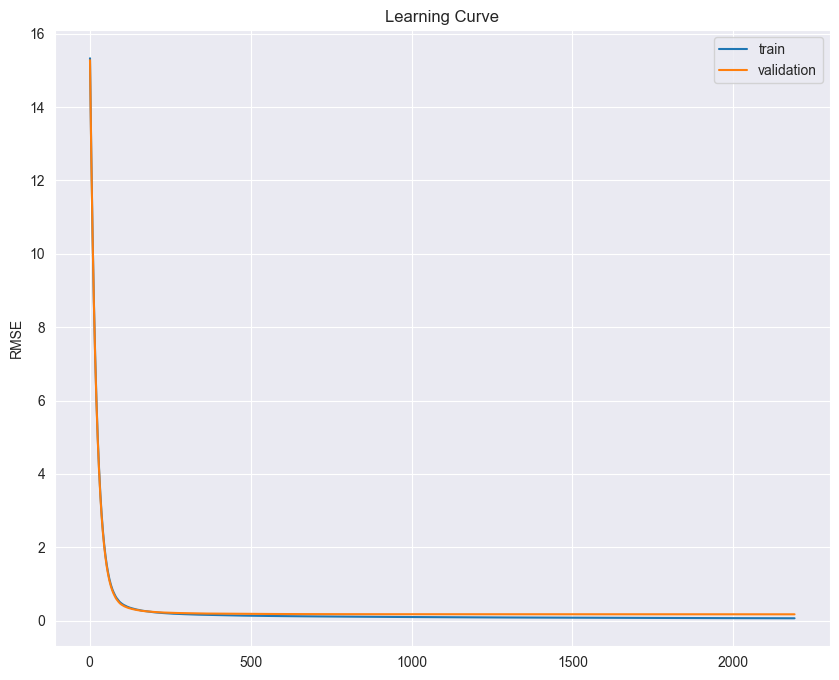

In [61]:
# Extract RMSE values for training and validation
train_rmse = evals_results['train']['rmse']
valid_rmse = evals_results['eval']['rmse']

# Plot the learning curve
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, label='train')
plt.plot(range(1, len(valid_rmse) + 1), valid_rmse, label='validation')
plt.title("Learning Curve")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [62]:
cv_results = xgb.cv(
    params=params,
    dtrain=d_X,
    num_boost_round=num_round,
    nfold=5,  # Number of folds for cross-validation
    stratified=False,  # This is for classification, set to False for regression
    metrics=('rmse', 'mae'),
    early_stopping_rounds=early_stop,
    verbose_eval=1000,
)

mean_rmse = cv_results['test-rmse-mean'].iloc[-1]
mean_mae = cv_results['test-mae-mean'].iloc[-1]

print("Cross-Validation RMSE:", mean_rmse)
print("Cross-Validation MAE:", mean_mae)

[0]	train-rmse:15.30983+0.00592	train-mae:15.28824+0.00608	test-rmse:15.30982+0.02379	test-mae:15.28825+0.02439
[1000]	train-rmse:0.09722+0.00184	train-mae:0.05510+0.00072	test-rmse:0.17663+0.02401	test-mae:0.09669+0.00338
[2000]	train-rmse:0.07057+0.00265	train-mae:0.03619+0.00071	test-rmse:0.17196+0.02486	test-mae:0.08777+0.00377
[2999]	train-rmse:0.05748+0.00280	train-mae:0.02749+0.00079	test-rmse:0.17068+0.02568	test-mae:0.08430+0.00409
Cross-Validation RMSE: 0.17067895423017723
Cross-Validation MAE: 0.08430316869961349


In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

# Split your data into folds manually
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
mae_scores = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # Predict using the trained model, make sure to matrix
    predictions = xgb_model.predict(xgb.DMatrix(X_val_fold))
    
    # Calculate RMSE and MAE for this fold
    rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, predictions)))
    mae_scores.append(mean_absolute_error(y_val_fold, predictions))

print("Cross-Validation RMSE Scores:", np.mean(rmse_scores))
print("Cross-Validation MAE Scores:", np.mean(mae_scores))

Cross-Validation RMSE Scores: 0.10500389748161834
Cross-Validation MAE Scores: 0.04967727916572394


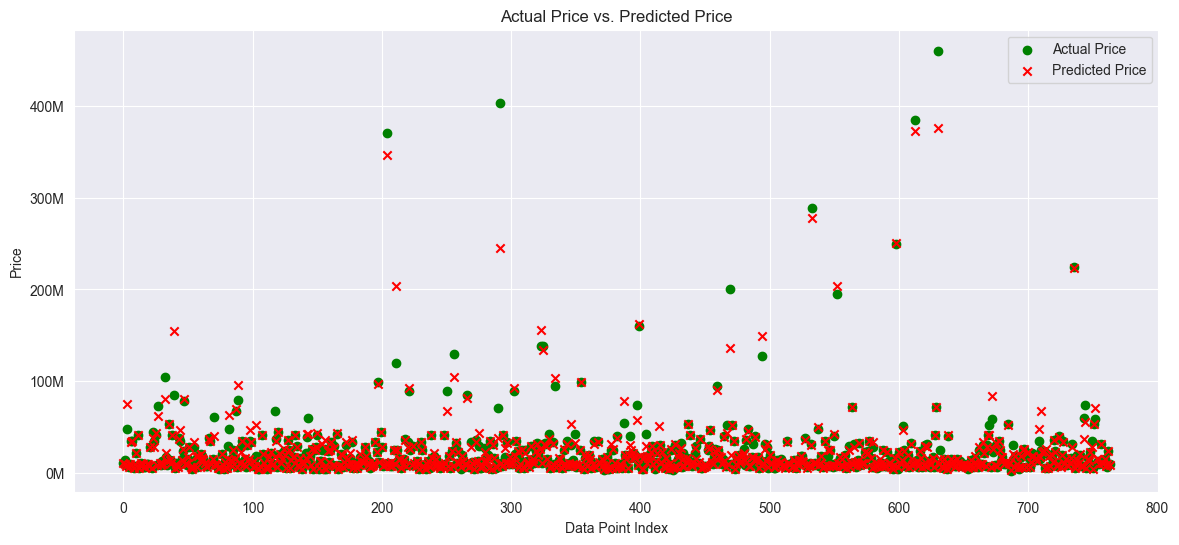

In [64]:
# Predict using the trained model
y_test_pred = xgb_model.predict(xgb.DMatrix(X_test))  # Predictions in DMatrix format

# Create a DataFrame of actual and predicted values
predicted_df = pd.DataFrame({'price': np.exp(y_test).astype('int64'), 'predicted_price': np.exp(y_test_pred).astype('int64')})

fig, ax = plt.subplots(figsize=(14, 6))

plt.scatter(x=range(len(predicted_df)), y=predicted_df.price, color='green', label="Actual Price")
plt.scatter(x=range(len(predicted_df)), y=predicted_df.predicted_price, color='red', marker="x", label="Predicted Price")

plt.title("Actual Price vs. Predicted Price")
plt.xlabel("Data Point Index")
plt.ylabel("Price")

# Get the y-axis object and set the formatter
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000):,}M')
ax.yaxis.set_major_formatter(formatter)

plt.legend()
plt.show()

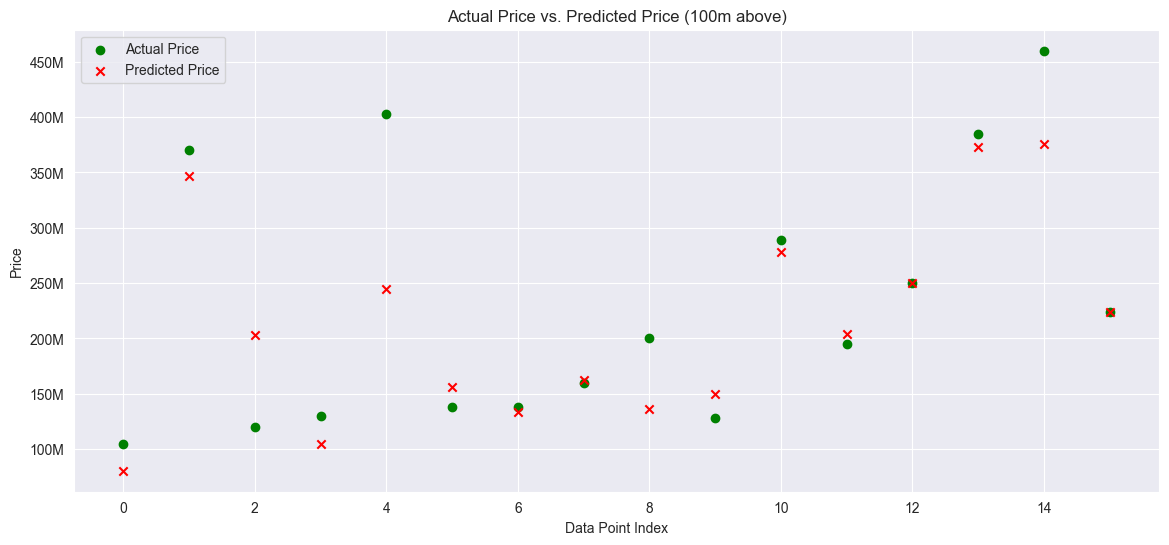

In [65]:
filtered_df = predicted_df.query('price > 100_000_000')

fig, ax = plt.subplots(figsize=(14, 6))

plt.scatter(x=range(len(filtered_df)), y=filtered_df.price, color='green', label="Actual Price")
plt.scatter(x=range(len(filtered_df)), y=filtered_df.predicted_price, color='red', marker="x", label="Predicted Price")

plt.title("Actual Price vs. Predicted Price (100m above)")
plt.xlabel("Data Point Index")
plt.ylabel("Price")

# Get the y-axis object and set the formatter
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000):,}M')
ax.yaxis.set_major_formatter(formatter)

plt.legend()
plt.show()

# Conclusion

After thoroughly analyzing different regression models, the clear winner is the RandomForestRegressor. It stands out for its exceptional performance compared to other methods like Ridge, Linear, and SVR Regression. Through cross-validation, it achieves the smallest errors in predictions, as shown by low Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) values.

What's particularly impressive about the RandomForestRegressor is how accurately it predicts values. As we use more training data, its predictions get better and better. This suggests that it's finding a good balance between learning from the data without getting too complicated.

On the other hand, the SVR and Ridge Regression models don't perform as well. Their errors are higher in cross-validation, and they don't seem to improve much with more data. It's like they can't learn more beyond a certain point.

Enter the XGBoost Regressor, which surpasses all the other models. It achieves remarkable scores and the lowest errors. It's excellent at fitting the data, as shown by a high Training R-squared value of 0.994 and Testing R-squared of 0.955. The Cross-Validation RMSE Scores of 0.105 and MAE Scores of 0.049 back up its strong predictive ability.

Both the RandomForestRegressor and XGBoost Regressor struggle when predicting values above 100 million. But the XGBoost model does a particularly good job, coming very close to the actual values, and even nailing some high-value predictions.

In conclusion, the RandomForestRegressor is a strong choice, but the XGBoost Regressor truly shines. It proves itself as a top performer, with exceptional predictive abilities even when faced with complex prediction challenges.

## XGBoost prediction 100m above:
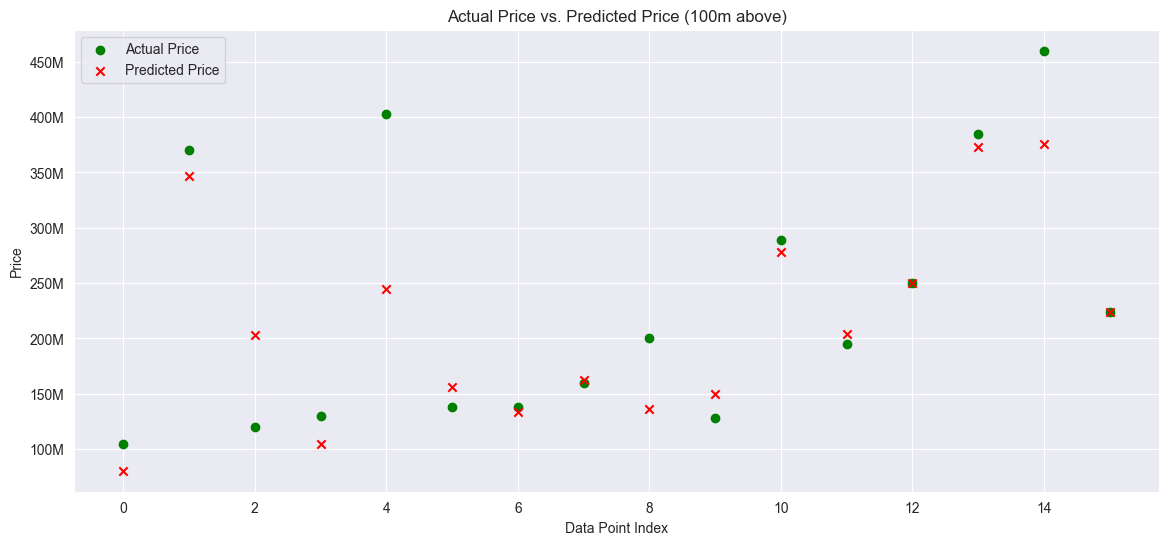

## RandomForestRegressor prediction 100m above:
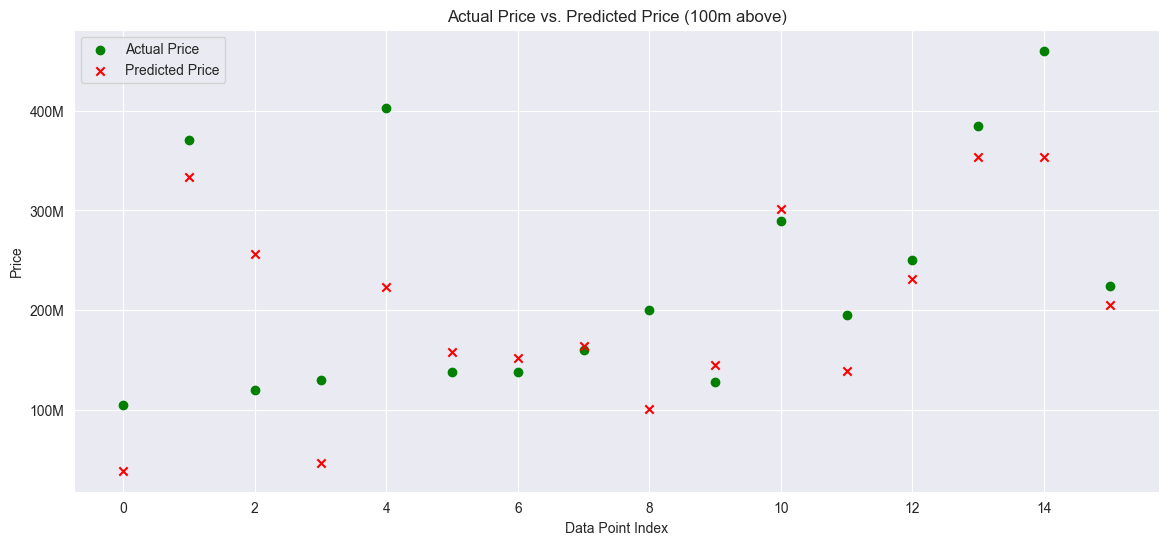